**Based on the model implemented in** <br />
Kunang, Y. N., Nurmaini, S., Stiawan, D., & Suprapto, B. Y. (2021). Attack classification of an intrusion detection system using deep learning and hyperparameter optimization. *Journal of Information Security and Applications*, *58*, 102804. https://doi.org/10.1016/j.jisa.2021.102804

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# NSL-KDD

### List of attributes

In [3]:
attributes = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
    'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate',
    'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
    'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
    'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','attack_type','classifiers'
]

In [4]:
len(attributes)

43

## Training Sets

### KDDTrain+.txt
header = None is used since the first line in the .txt file is a record (a feature vector) <br />
index_col = False is used to avoid the automatic use of the first column as an index

In [5]:
train_set = pd.read_csv('KDDTrain+.txt', header = None, index_col = False, names = attributes)

In [6]:
services = train_set['service'].unique()
flags = train_set['flag'].unique()
protocols = train_set['protocol_type'].unique()

### KDDTrain+_20Percent.txt

In [7]:
train_set_20 = pd.read_csv('KDDTrain+_20Percent.txt', header = None, index_col = False, names = attributes)

## Test Sets

### KDDTest+.txt

In [8]:
test_set = pd.read_csv('KDDTest+.txt', header = None, index_col = False, names = attributes)

### KDDTest-21.txt

In [9]:
test_set_21 = pd.read_csv('KDDTest-21.txt', header = None, index_col = False, names = attributes)

# Data Inspection

In [10]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df.isnull().sum().sum())

0
0
0
0


There are no missing values in the dataset

In [11]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    for col in attributes:
        if(df[col].nunique()<2):
            print(col)

num_outbound_cmds
num_outbound_cmds
is_host_login
num_outbound_cmds
num_outbound_cmds


In [12]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['num_outbound_cmds'].unique())

[0]
[0]
[0]
[0]


In [13]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['service'].nunique())

70
66
64
62


In [14]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['service'].unique(), services)
    print((isTrue == True).all())

True
True
True


The service values are the same accross the entire dataset. **However**, KDDTrain20Percent and both train datasets do not have all the services which will cause a problem in encoding

In [15]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['flag'].nunique())

11
11
11
11


In [16]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['flag'].unique(), flags)
    print((isTrue == True).all())

True
True
True


The flag values are the same accross the entire dataset.

In [17]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    print(df['protocol_type'].nunique())

3
3
3
3


In [18]:
for df in [train_set_20, test_set, test_set_21]:
    isTrue = np.isin(df['protocol_type'].unique(), protocols)
    print((isTrue == True).all())

True
True
True


The protocol values are the same accross the entire dataset.

# Data Preprocessing

Since **num_outbound_cmds** has only one value in the whole dataset, this column will be dropped since it has no effect on classification

In [19]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    df.drop('num_outbound_cmds', axis = 1, inplace=True)

**classifiers** attribute is only useful for determining the level of difficulty of the record which would have no effect on classification

In [20]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    df.drop('classifiers', axis = 1, inplace=True)

General method for removing labels

In [21]:
def remove_labels(df, labels):
    df.drop(labels, axis = 1, inplace = True)

## 1. Adding columns

In [22]:
def add_missing_cols(df):
    missing = np.setdiff1d(services, df['service'].unique())
    for col in missing:
        df['service_{col}'.format(col = col)] = 0
    return df

### Adding attack categories column for multi-class classification

In [23]:
def categorize(str):
    if str in ['back', 'land', 'neptune', 'pod', 'smurf', 'mailbomb','teardrop','apache2', 'udpstorm', 'processtable', 'worm']:
        return 'dos'
    elif str in ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named']:
        return 'r2l'
    elif str in ['buffer_overflow', 'loadmodule', 'rootkit', 'perl', 'sqlattack', 'xterm', 'ps']:
        return 'u2r'
    elif str in ['satan', 'ipsweep', 'nmap', 'portsweep', 'mscan', 'saint']:
        return 'probe'
    else:
        return 'normal'
    
def categorize_attacks(df):
    df['category'] = np.vectorize(categorize)(df['attack_type'])

def display_categories(df):
    order = ['normal', 'dos', 'probe', 'r2l', 'u2r']
    sns.countplot(x=df['category'], data = df, order=order);

In [24]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    categorize_attacks(df)

All attacks were categorized

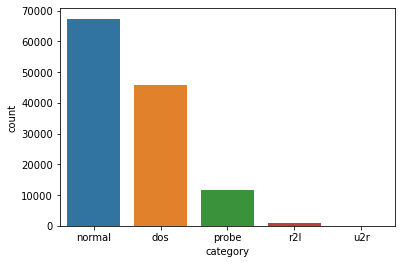

In [25]:
display_categories(train_set)

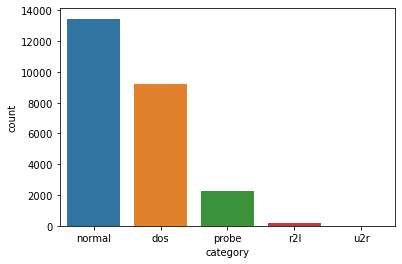

In [26]:
display_categories(train_set_20)

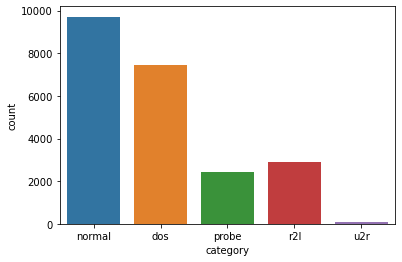

In [27]:
display_categories(test_set)

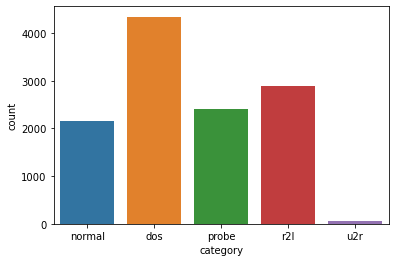

In [28]:
display_categories(test_set_21)

### Adding labels 'normal' or 'attack' for binary classification

In [29]:
def binary_labels(str):
    if str in ['dos', 'r2l', 'probe', 'u2r']:
        return 'attack'
    else:
        return 'normal'
    
    
def add_binary_labels(df):
    df['traffic_type'] = np.vectorize(binary_labels)(df['category'])
    
def display_traffic_type(df):
    order = ['normal', 'attack']
    sns.countplot(x=df['traffic_type'], data = df, order=order);

In [30]:
for df in [train_set, train_set_20, test_set, test_set_21]:
    add_binary_labels(df)

Binary labels were added

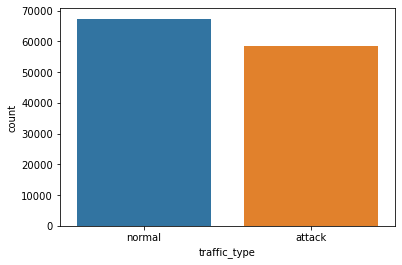

In [31]:
display_traffic_type(train_set)

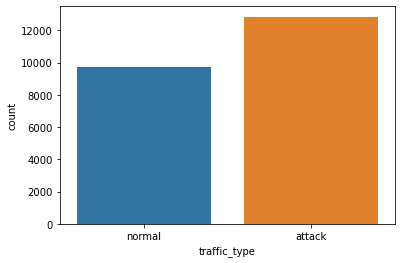

In [32]:
display_traffic_type(test_set)

## 2. Normalization

In [33]:
from sklearn.preprocessing import MinMaxScaler

excl_cols = ['protocol_type', 'service', 'flag', 'category', 'traffic_type', 'attack_type', 'classifiers',
        'land', 'logged_in', 'is_host_login', 'is_guest_login']

def min_max_norm(df):
    scaler = MinMaxScaler()
    norm_cols = np.setdiff1d(df.columns, excl_cols)
    df[norm_cols] = scaler.fit_transform(df[norm_cols])

## 3. Feature Encoding

### Label Encoder

In [34]:
from sklearn.preprocessing import LabelEncoder

def label_encode(df, cols):
    le = LabelEncoder()
    df[cols] = df[cols].apply(le.fit_transform)
    mapping = dict(zip(le.classes_, range(len(le.classes_))))
    return mapping

### One-hot Encoder

In [35]:
def hot_encode(df, categorical_columns = ['protocol_type', 'service', 'flag']):
    return pd.get_dummies(data=df, columns=categorical_columns, dtype='int8')

In [36]:
def split(df, col):
    r = pd.DataFrame(df[col])
    df.drop(col, axis = 1, inplace = True)
    return r

In [71]:
def prep_4_class(df, add = True, without = False):
    n = df.copy()
    min_max_norm(n)
    
    if(without):
        attacks = train_set['attack_type'].unique()
        new_attacks = np.setdiff1d(n['attack_type'].unique(), attacks)

        for a in new_attacks:
            rows = n[n['attack_type'] == a]
            n.drop(rows.index, axis=0, inplace=True)
    if(add):
        n = add_missing_cols(n)
    
    h = hot_encode(n)
    r = h[h['category'] == 'normal']
    h.drop(r.index, axis = 0, inplace = True)
    l = split(h, ['category'])
    remove_labels(h, ['attack_type', 'traffic_type'])
    lh = hot_encode(l, ['category'])
    lm = label_encode(l, ['category'])
    return (h, lh, lm, l)  #hot encoded set, hot encoded labels, label encoding mapping, original labels

In [72]:
def prep_2_class(df):
    n = df.copy()
    min_max_norm(n)
    h = hot_encode(n)
    l = split(h, ['traffic_type'])
    remove_labels(h, ['attack_type', 'category'])
    lh = hot_encode(l, ['traffic_type'])
    lm = label_encode(l, ['traffic_type'])
    return (h, lh, lm, l)

#### Splitting KDDTrain+ dataset:

In [73]:
X_train, y_train, train_label_mapping, train_labels = prep_4_class(train_set, False)

#### Splitting KDDTest+ dataset:

In [75]:
X_test, y_test, test_label_mapping, test_labels = prep_4_class(test_set)

In [76]:
X_test_w, y_test_w, test_label_mapping_w, test_labels_w = prep_4_class(test_set, without = True)

# Autoencoder and DNN

In [41]:
import tensorflow as tf
from tensorflow import keras

In [42]:
#for reproducable results
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

### Training for 4-class classification

## Deep Autoencoder

In [43]:
encoder = keras.models.Sequential(name = 'encoder')                 
encoder.add(keras.layers.Dense(100, activation = 'relu', input_shape = (121, ), kernel_initializer = 'he_uniform'))
encoder.add(keras.layers.Dense(20, activation = 'relu', kernel_initializer = 'he_uniform'))

decoder = keras.models.Sequential(name = 'decoder')
decoder.add(keras.layers.Dense(100, activation='relu', input_shape = (20, ), kernel_initializer = 'he_uniform')) 
decoder.add(keras.layers.Dense(121, activation='sigmoid', kernel_initializer = 'he_uniform'))

deep_ae = keras.models.Sequential([
    encoder,
    decoder
])

deep_ae.compile(
    loss = 'binary_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01)
)

deep_ae_history = deep_ae.fit(X_train, X_train, batch_size= 256, epochs=30)

Epoch 1/30
230/230 [==============================] - 1s 2ms/step - loss: 0.0460
Epoch 2/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 3/30
230/230 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 4/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 5/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0164
Epoch 6/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 7/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 8/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 9/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 10/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 11/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0160
Epoch 12/30
230/230 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 13/30
230/230 [====

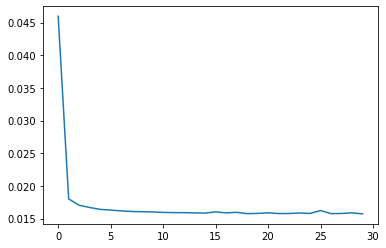

In [63]:
plt.plot(deep_ae_history.history['loss']);

## DNN

In [45]:
encoder_layers = deep_ae.get_layer('encoder')
encoder_layers.trainable = False

dnn = keras.models.Sequential([ 
    encoder_layers,
    keras.layers.Dense(4, input_shape=(20, ), activation = 'softmax', kernel_initializer = 'he_uniform')
])

dnn.compile(
    loss = 'categorical_crossentropy',
    optimizer= keras.optimizers.Adam(learning_rate=0.01),
    metrics = ['accuracy']
              
)
               
#tf.keras.metrics.Precision(), tf.keras.metrics.Recall()

dnn_history = dnn.fit(X_train, y_train, batch_size= 256, epochs=100)

Epoch 1/100
230/230 [==============================] - 0s 743us/step - loss: 0.1628 - accuracy: 0.9558
Epoch 2/100
230/230 [==============================] - 0s 687us/step - loss: 0.0440 - accuracy: 0.9902
Epoch 3/100
230/230 [==============================] - 0s 718us/step - loss: 0.0359 - accuracy: 0.9919
Epoch 4/100
230/230 [==============================] - 0s 683us/step - loss: 0.0349 - accuracy: 0.9917
Epoch 5/100
230/230 [==============================] - 0s 670us/step - loss: 0.0320 - accuracy: 0.9927
Epoch 6/100
230/230 [==============================] - 0s 669us/step - loss: 0.0314 - accuracy: 0.9927
Epoch 7/100
230/230 [==============================] - 0s 686us/step - loss: 0.0309 - accuracy: 0.9925
Epoch 8/100
230/230 [==============================] - 0s 669us/step - loss: 0.0304 - accuracy: 0.9928
Epoch 9/100
230/230 [==============================] - 0s 703us/step - loss: 0.0300 - accuracy: 0.9930
Epoch 10/100
230/230 [==============================] - 0s 683us/step - l

Epoch 80/100
230/230 [==============================] - 0s 640us/step - loss: 0.0285 - accuracy: 0.9926
Epoch 81/100
230/230 [==============================] - 0s 646us/step - loss: 0.0288 - accuracy: 0.9928
Epoch 82/100
230/230 [==============================] - 0s 645us/step - loss: 0.0287 - accuracy: 0.9927
Epoch 83/100
230/230 [==============================] - 0s 645us/step - loss: 0.0318 - accuracy: 0.9916
Epoch 84/100
230/230 [==============================] - 0s 687us/step - loss: 0.0283 - accuracy: 0.9926
Epoch 85/100
230/230 [==============================] - 0s 673us/step - loss: 0.0284 - accuracy: 0.9925
Epoch 86/100
230/230 [==============================] - 0s 675us/step - loss: 0.0285 - accuracy: 0.9925
Epoch 87/100
230/230 [==============================] - 0s 677us/step - loss: 0.0284 - accuracy: 0.9929
Epoch 88/100
230/230 [==============================] - 0s 656us/step - loss: 0.0281 - accuracy: 0.9927
Epoch 89/100
230/230 [==============================] - 0s 636us

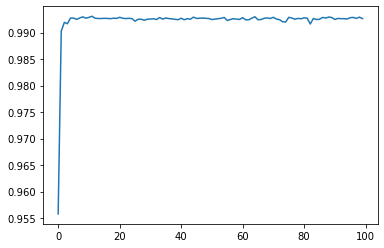

In [64]:
plt.plot(dnn_history.history['accuracy']);

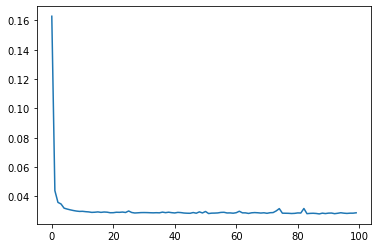

In [65]:
plt.plot(dnn_history.history['loss']);

# Best Results

### KDDTrain+

!!!! 
* Recall = True Positive Rate (TPR)

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def metrics(y, pred):
    print('\nOverall accuracy: {:.2f}\n'.format(accuracy_score(y, pred)))

    print('\nClassification report\n')
    print(classification_report(y, pred, target_names=['dos', 'probe', 'r2l', 'u2r']))
    
    confusion = confusion_matrix(y, pred)
    acc = confusion.diagonal() * 100 / confusion.sum(axis=1)
    print('\nAccuracy per Class:\n\ndos\t {:.2f}'.format(acc[0]))
    print('probe\t {:.2f}'.format(acc[1]))
    print('r2l\t {:.2f}'.format(acc[2]))
    print('u2r\t {:.2f}'.format(acc[3]))

In [51]:
dnn.load_weights('good training-better test.h5')  #previously saved weights that provided the best results

In [61]:
yhat_train = dnn.predict(X_train)
yhat_train_labels = [np.argmax(i) for i in yhat_train]
cm_train = tf.math.confusion_matrix(labels = train_labels, 
                               predictions = yhat_train_labels)

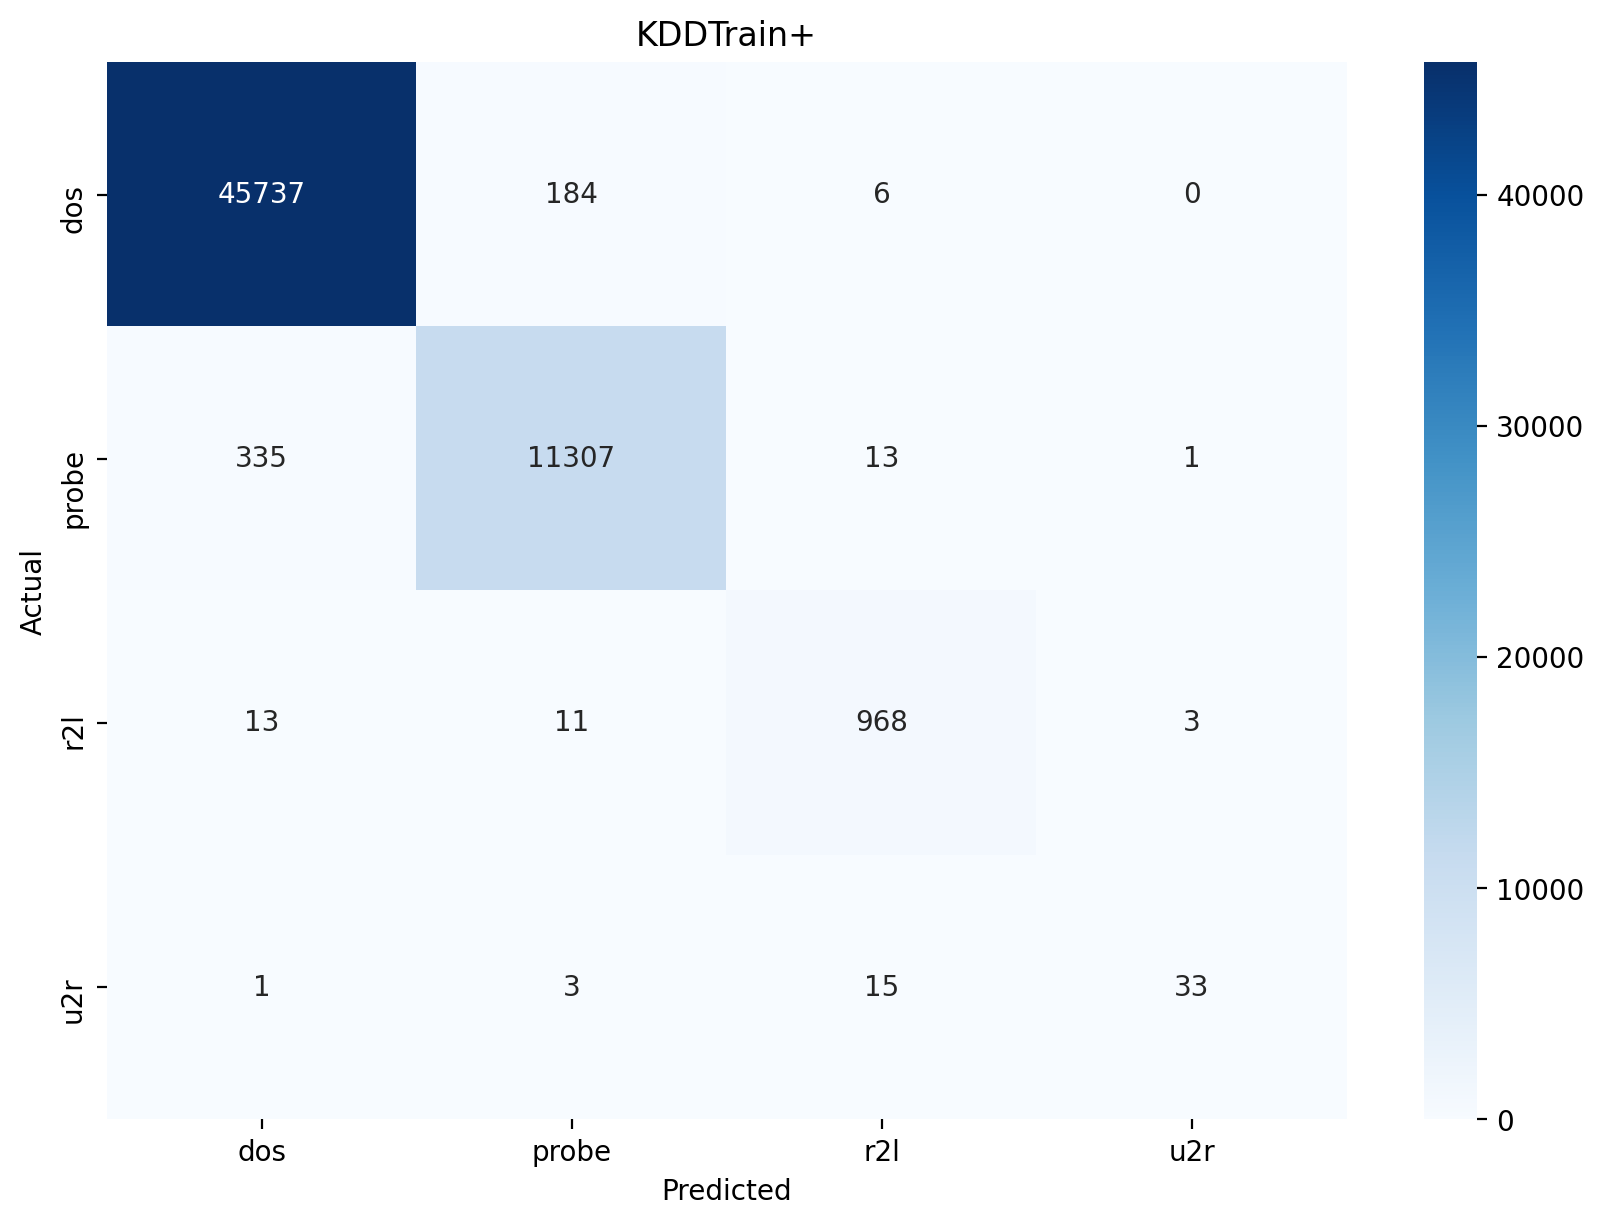

In [62]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTrain+')
sns.heatmap(cm_train, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = train_label_mapping.keys(),
           yticklabels = train_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [125]:
metrics(train_labels, yhat_train_labels)


Overall accuracy: 0.99


Classification report

              precision    recall  f1-score   support

         dos       0.99      1.00      0.99     45927
       probe       0.98      0.97      0.98     11656
         r2l       0.97      0.97      0.97       995
         u2r       0.89      0.63      0.74        52

    accuracy                           0.99     58630
   macro avg       0.96      0.89      0.92     58630
weighted avg       0.99      0.99      0.99     58630


Accuracy per Class:

dos	 99.59
probe	 97.01
r2l	 97.29
u2r	 63.46


### KDDTest+ (with new attacks)

In [77]:
yhat_test = dnn.predict(X_test)
yhat_test_labels = [np.argmax(i) for i in yhat_test]
cm_test = tf.math.confusion_matrix(labels = test_labels, 
                              predictions = yhat_test_labels)

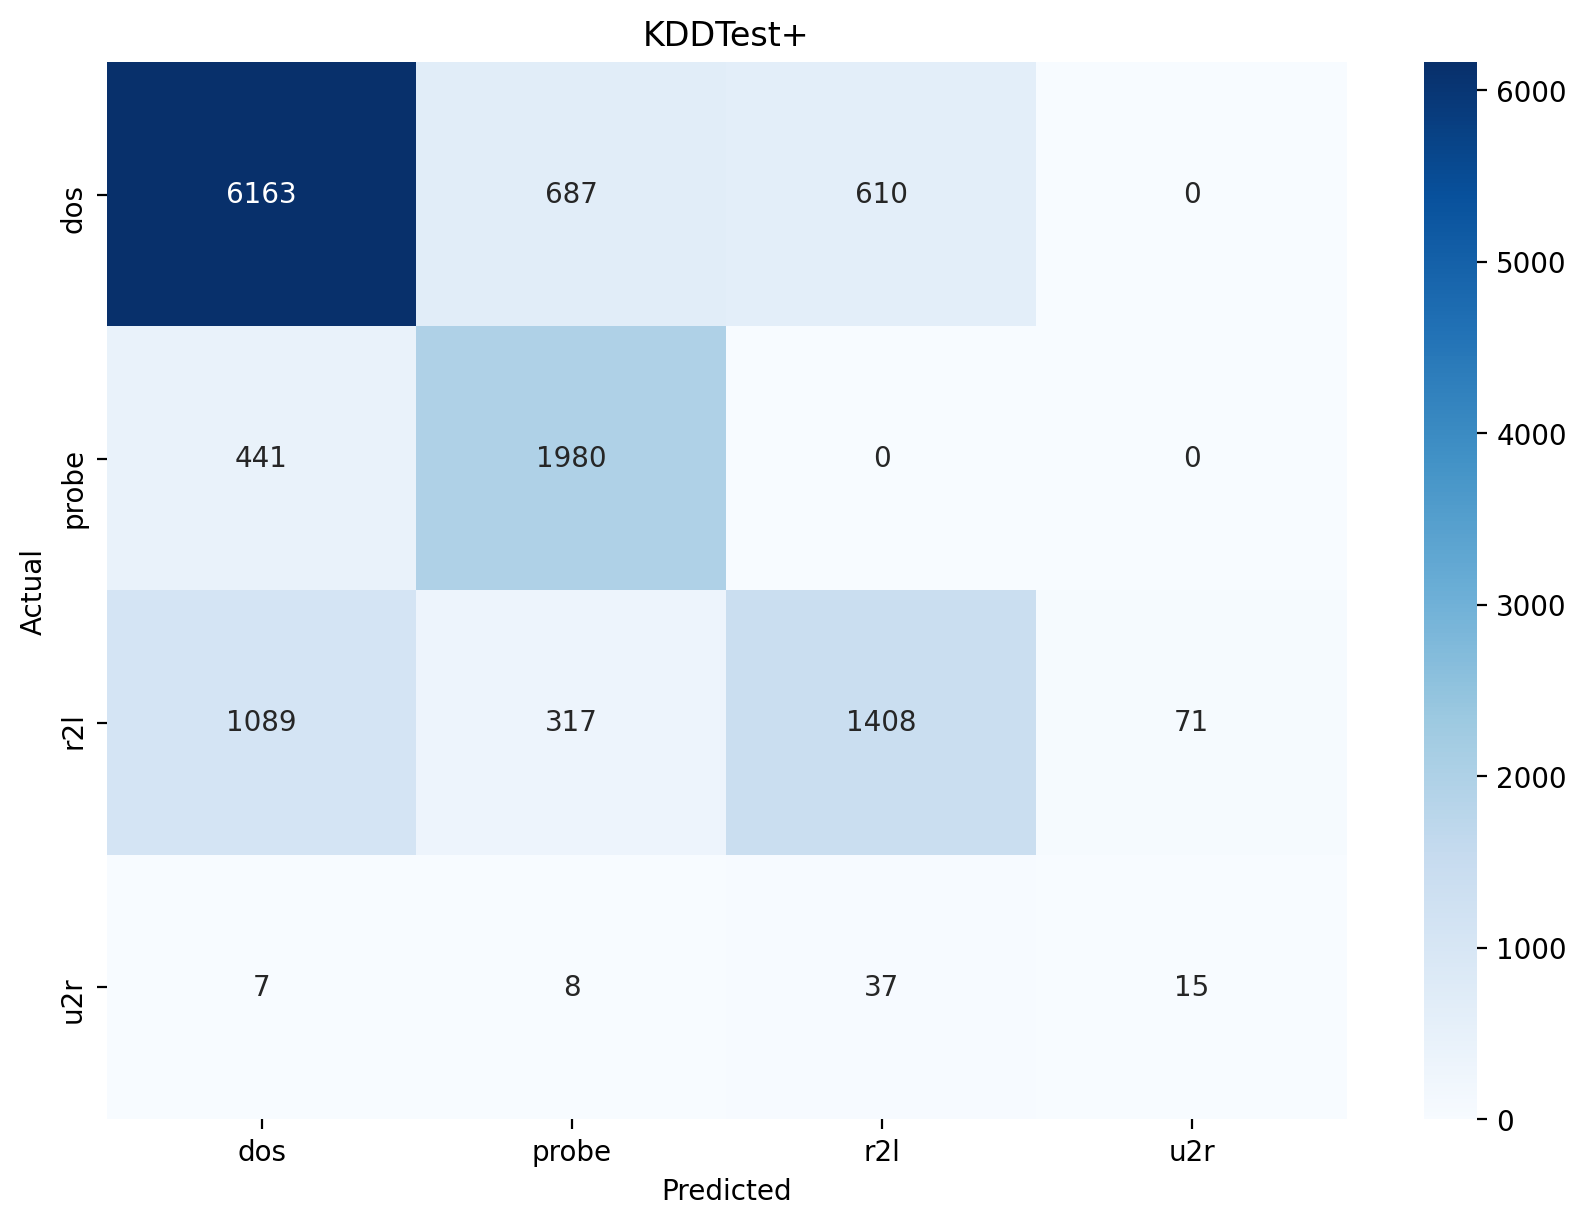

In [56]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+')
sns.heatmap(cm_test, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping.keys(),
           yticklabels = test_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [126]:
metrics(test_labels, yhat_test_labels)


Overall accuracy: 0.75


Classification report

              precision    recall  f1-score   support

         dos       0.80      0.83      0.81      7460
       probe       0.66      0.82      0.73      2421
         r2l       0.69      0.49      0.57      2885
         u2r       0.17      0.22      0.20        67

    accuracy                           0.75     12833
   macro avg       0.58      0.59      0.58     12833
weighted avg       0.75      0.75      0.74     12833


Accuracy per Class:

dos	 82.61
probe	 81.78
r2l	 48.80
u2r	 22.39


### KDDTest+ (without new attacks)

In [79]:
yhat_test_w = dnn.predict(X_test_w)
yhat_test_labels_w = [np.argmax(i) for i in yhat_test_w]
cm_test_w = tf.math.confusion_matrix(labels = test_labels_w, 
                              predictions = yhat_test_labels_w)

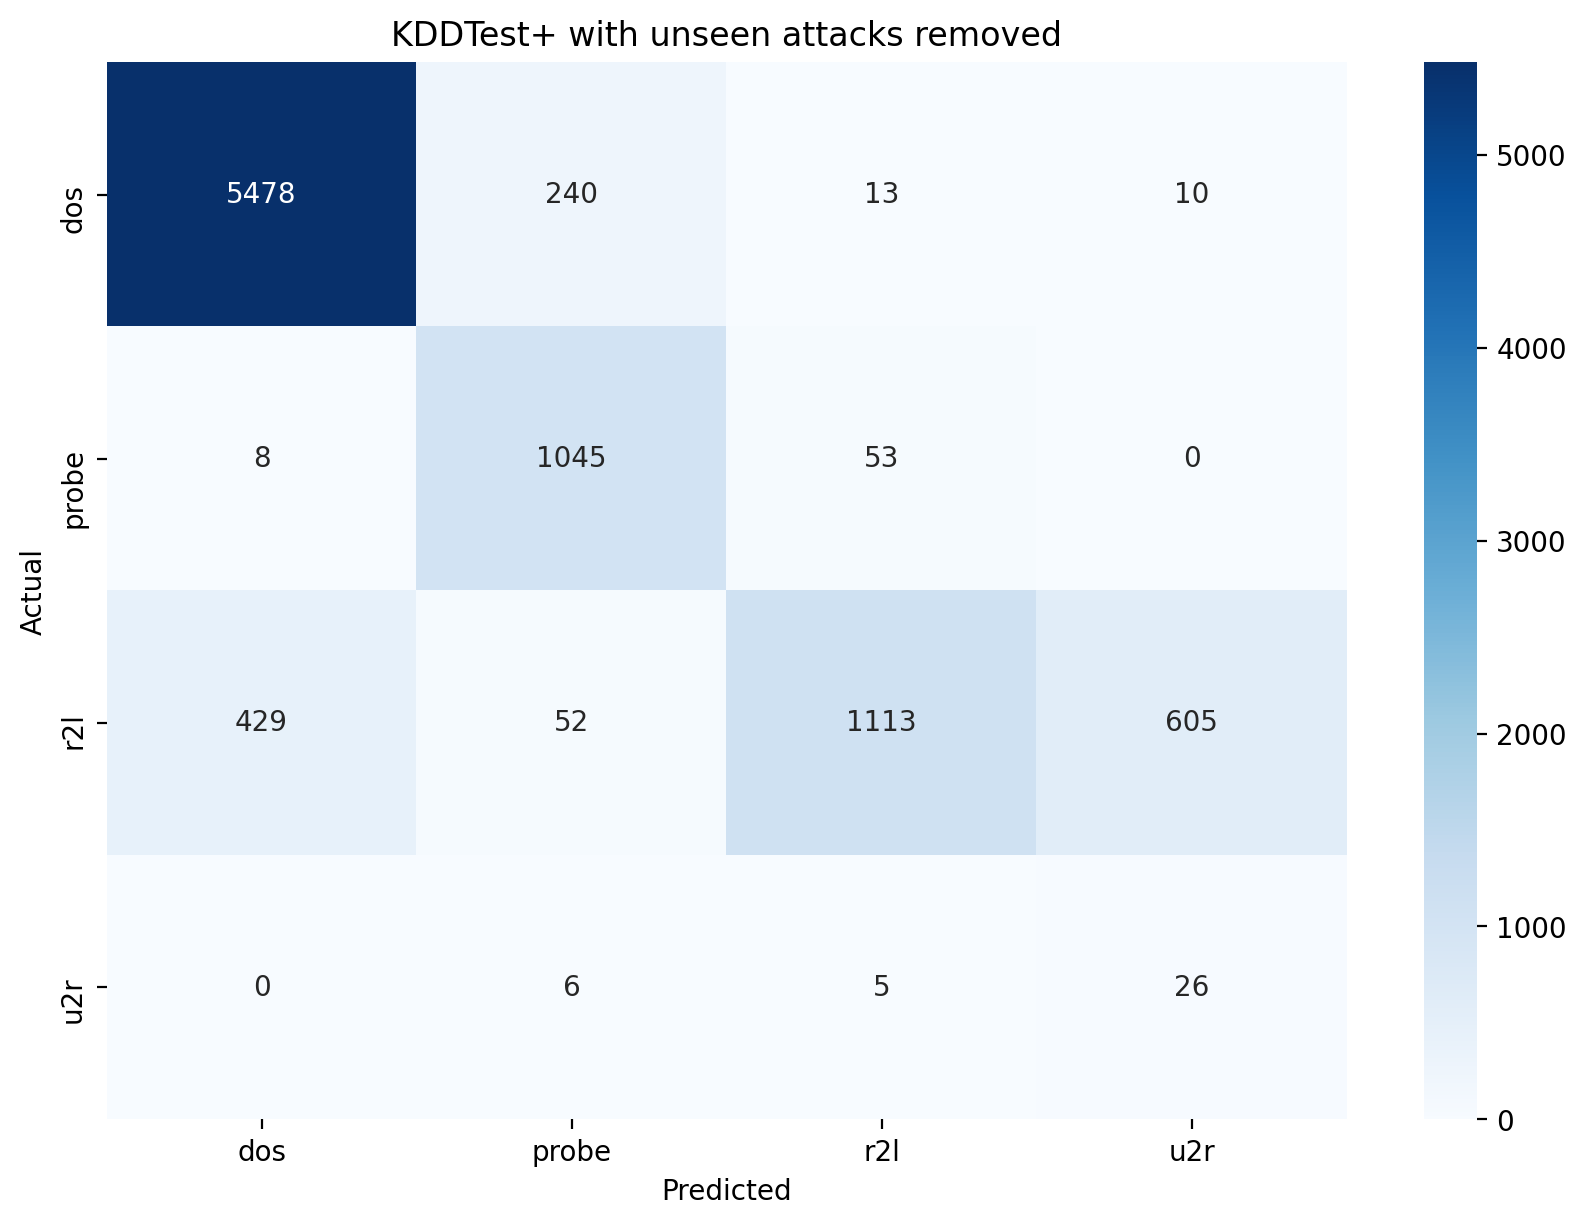

In [81]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest+ with unseen attacks removed')
sns.heatmap(cm_test_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_label_mapping.keys(),
           yticklabels = test_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [127]:
metrics(test_labels_w, yhat_test_labels_w)


Overall accuracy: 0.84


Classification report

              precision    recall  f1-score   support

         dos       0.93      0.95      0.94      5741
       probe       0.78      0.94      0.85      1106
         r2l       0.94      0.51      0.66      2199
         u2r       0.04      0.70      0.08        37

    accuracy                           0.84      9083
   macro avg       0.67      0.78      0.63      9083
weighted avg       0.91      0.84      0.86      9083


Accuracy per Class:

dos	 95.42
probe	 94.48
r2l	 50.61
u2r	 70.27


### KDD Test -21 (with new attacks)

In [82]:
X_test_21, y_test_21, test_21_label_mapping, test_21_labels = prep_4_class(test_set_21)

In [83]:
yhat_21 = dnn.predict(X_test_21)
yhat_21_labels = [np.argmax(i) for i in yhat_21]
cm_21 = tf.math.confusion_matrix(labels = test_21_labels, 
                                 predictions = yhat_21_labels)

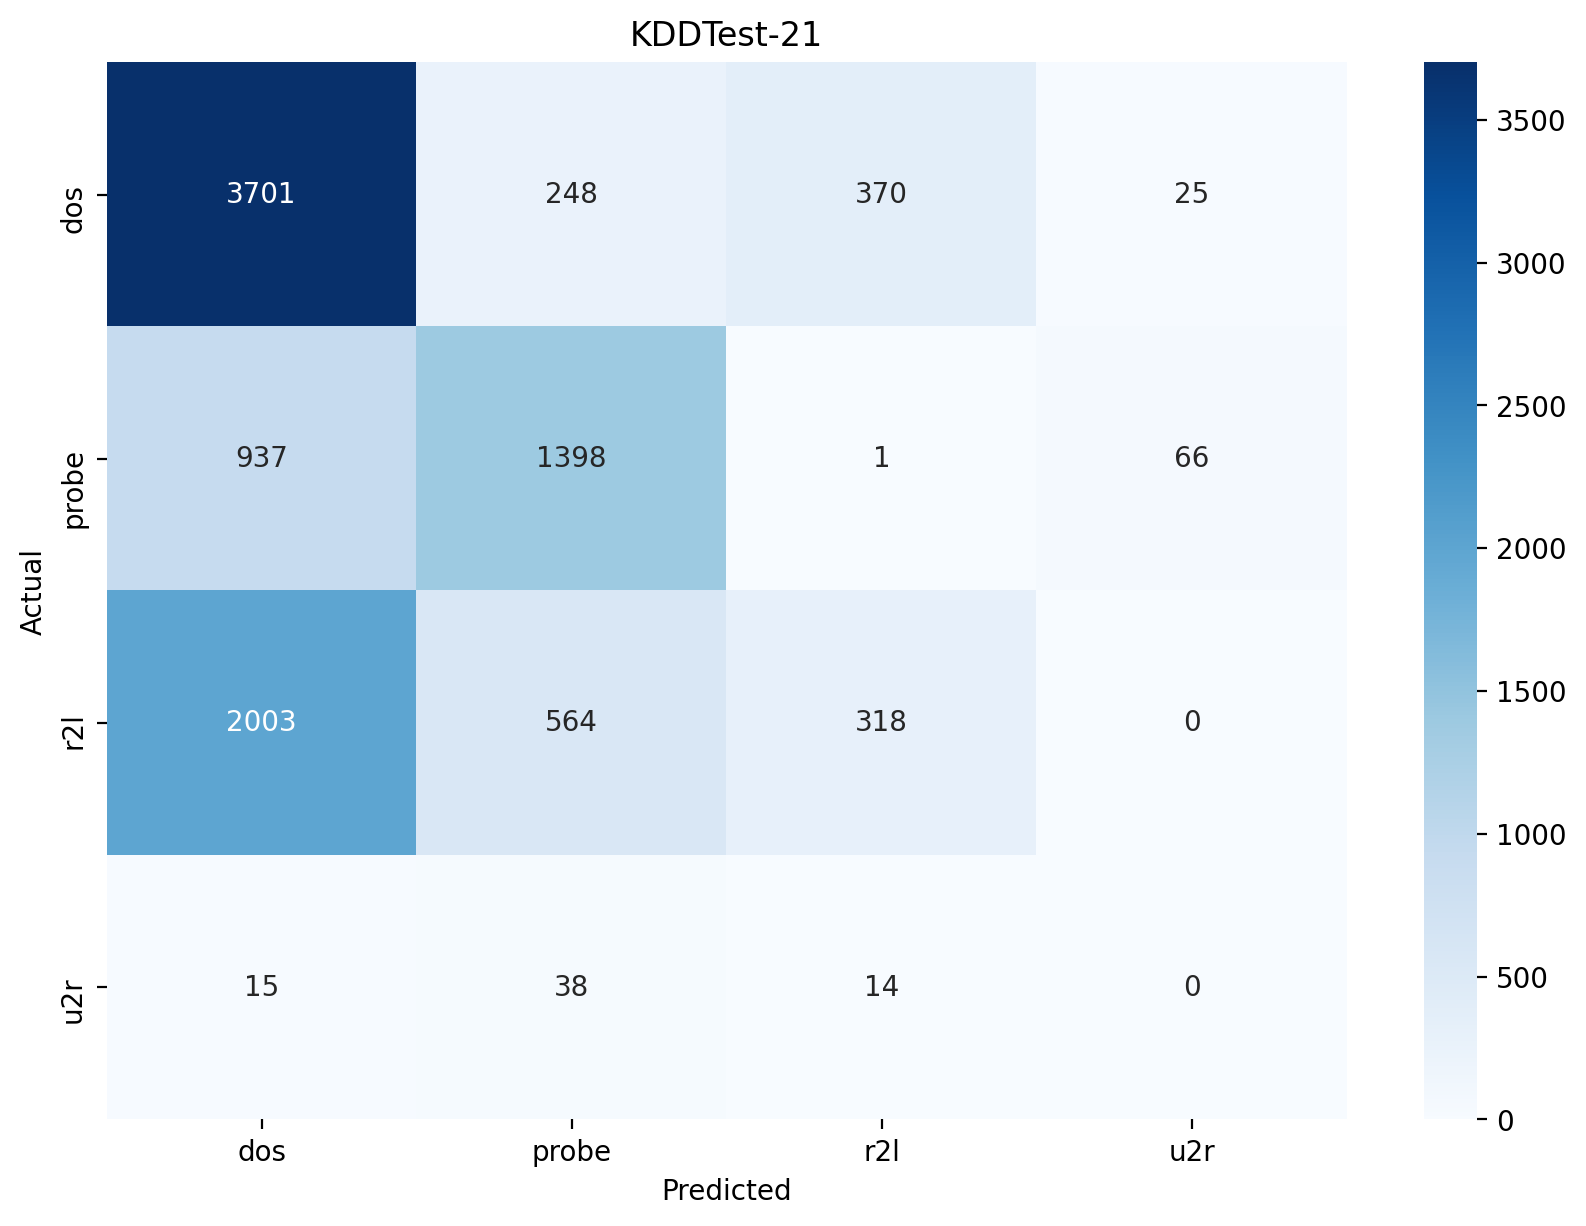

In [84]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest-21')
sns.heatmap(cm_21, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping.keys(),
           yticklabels = test_21_label_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [129]:
metrics(test_21_labels, yhat_21_labels)


Overall accuracy: 0.56


Classification report

              precision    recall  f1-score   support

         dos       0.56      0.85      0.67      4344
       probe       0.62      0.58      0.60      2402
         r2l       0.45      0.11      0.18      2885
         u2r       0.00      0.00      0.00        67

    accuracy                           0.56      9698
   macro avg       0.41      0.39      0.36      9698
weighted avg       0.54      0.56      0.50      9698


Accuracy per Class:

dos	 85.20
probe	 58.20
r2l	 11.02
u2r	 0.00


### KDDTest -21 (without new attacks)

In [85]:
X_test_21_w, y_test_21_w, test_21_label_mapping_w, test_21_labels_w = prep_4_class(test_set_21, without = True)

In [86]:
yhat_21_w = dnn.predict(X_test_21_w)
yhat_21_labels_w = [np.argmax(i) for i in yhat_21_w]
cm_21_w = tf.math.confusion_matrix(labels = test_21_labels_w, 
                                 predictions = yhat_21_labels_w)

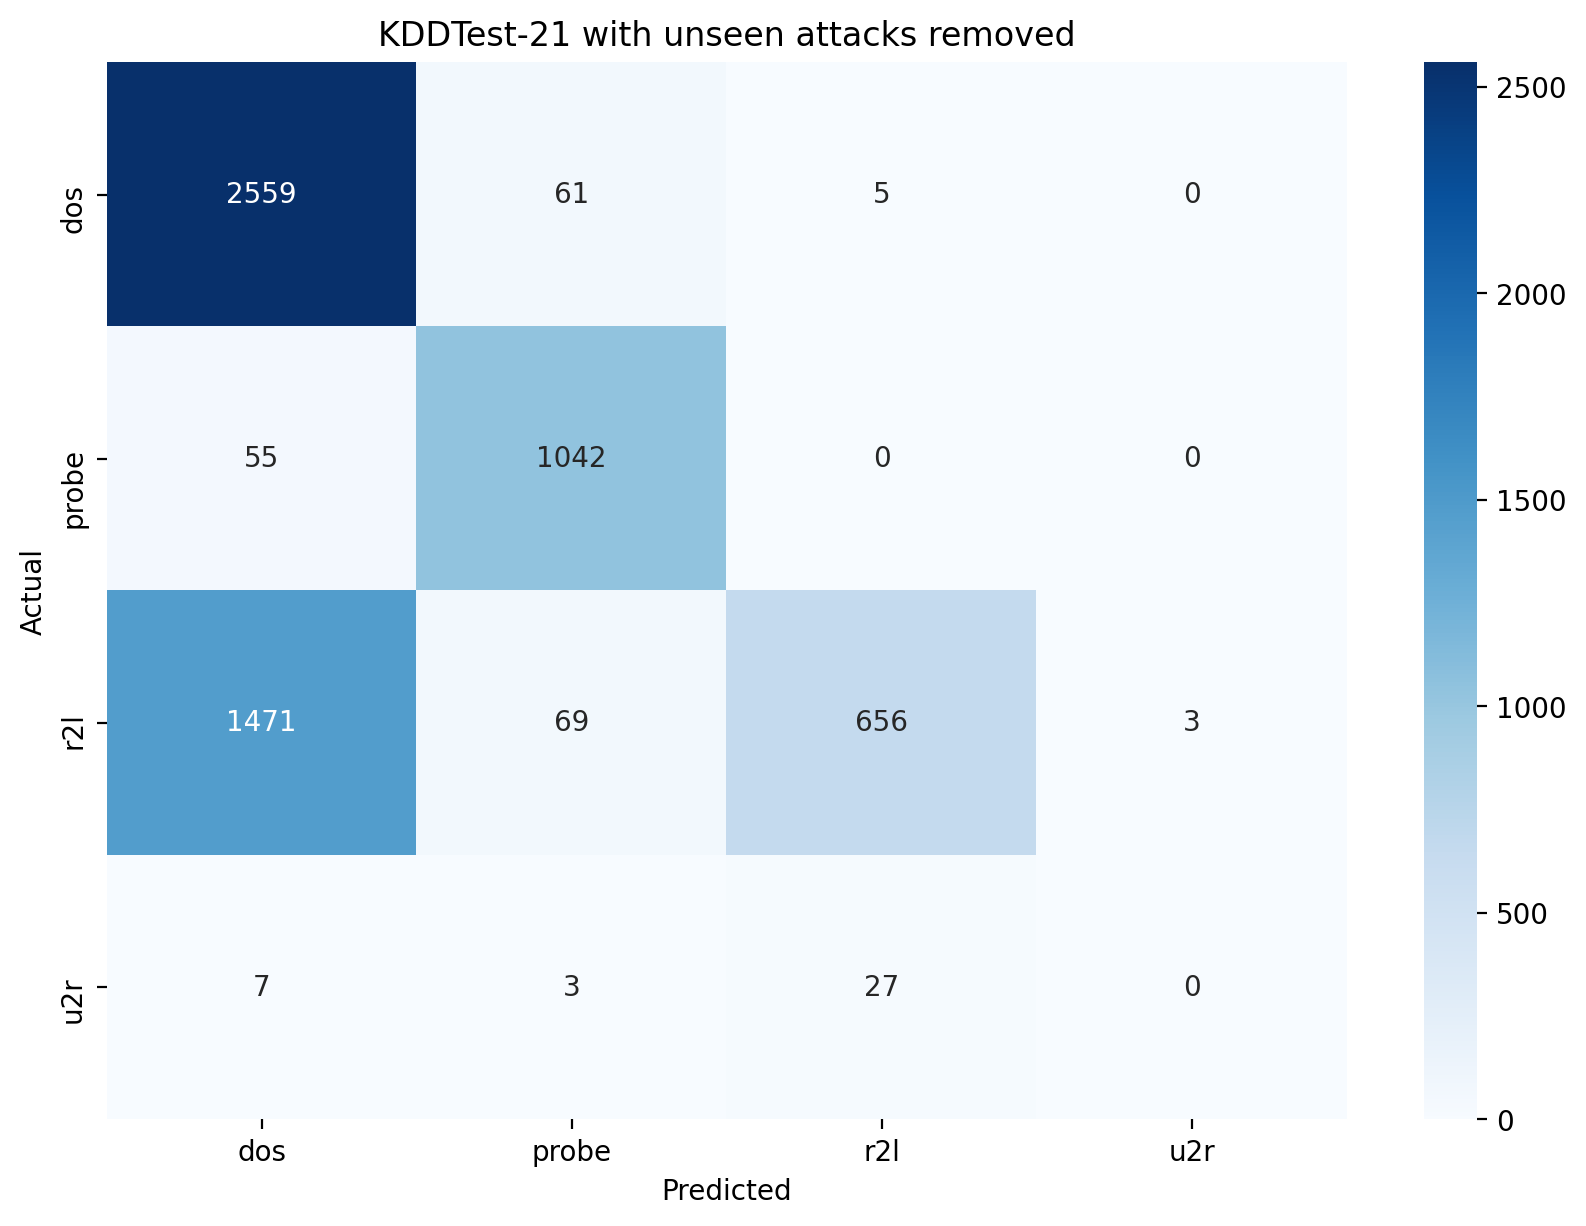

In [130]:
plt.figure(figsize =(10,7), dpi = 200)
plt.title('KDDTest-21 with unseen attacks removed')
sns.heatmap(cm_21_w, annot=True, fmt='d', cmap = 'Blues',
           xticklabels = test_21_label_mapping_w.keys(),
           yticklabels = test_21_label_mapping_w.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [131]:
metrics(test_21_labels_w, yhat_21_labels_w)


Overall accuracy: 0.71


Classification report

              precision    recall  f1-score   support

         dos       0.63      0.97      0.76      2625
       probe       0.89      0.95      0.92      1097
         r2l       0.95      0.30      0.45      2199
         u2r       0.00      0.00      0.00        37

    accuracy                           0.71      5958
   macro avg       0.62      0.56      0.53      5958
weighted avg       0.79      0.71      0.67      5958


Accuracy per Class:

dos	 97.49
probe	 94.99
r2l	 29.83
u2r	 0.00
